# GAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import pandas as pd # Added for data loading
from tqdm import tqdm # Added for progress bar

# Ensure deterministic behavior for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- 1. Define the Conditional Graph VAE Model ---
# Using ConditionalGraphVAE_Updated as the primary model class.

class ConditionalGraphVAE_Updated(nn.Module):
    def __init__(self, node_feature_dim, property_dim, hidden_dim, latent_dim, max_nodes_for_decode):
        """
        Initializes the Conditional Graph Variational Autoencoder.

        Args:
            node_feature_dim (int): Dimension of input node features.
            property_dim (int): Dimension of the property vector.
            hidden_dim (int): Dimension of the hidden layers in GNNs.
            latent_dim (int): Dimension of the latent space.
            max_nodes_for_decode (int): Maximum number of nodes the decoder can generate/reconstruct for.
        """
        super(ConditionalGraphVAE_Updated, self).__init__()

        self.node_feature_dim = node_feature_dim
        self.property_dim = property_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.max_nodes_for_decode = max_nodes_for_decode # Store this for the decoder

        # --- Encoder ---
        # The encoder takes node features (x) and the property (y)
        # We concatenate the property to each node's feature vector.
        # This allows the GNN to learn property-aware node representations.
        self.encoder_conv1 = GCNConv(node_feature_dim + property_dim, hidden_dim)
        self.encoder_conv2 = GCNConv(hidden_dim, hidden_dim)

        # Output layers for mean and log-variance of the latent distribution
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # --- Decoder ---
        # The decoder takes a latent vector (z) and the property (y)
        # It aims to reconstruct the adjacency matrix.
        # We concatenate the property to the latent vector.
        self.decoder_fc1 = nn.Linear(latent_dim + property_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Final layer to predict flattened adjacency matrix
        # The output size is fixed based on the maximum number of nodes in the dataset.
        self.decoder_fc_adj = nn.Linear(hidden_dim, max_nodes_for_decode * max_nodes_for_decode)

    def encode(self, x, edge_index, batch, y):
        """
        Encodes the input graph and property into a latent distribution.

        Args:
            x (torch.Tensor): Node feature matrix.
            edge_index (torch.Tensor): Graph connectivity.
            batch (torch.Tensor): Batch vector, mapping each node to its respective graph in the batch.
            y (torch.Tensor): Property vector for each graph in the batch.

        Returns:
            tuple: (mu, logvar) - mean and log-variance of the latent distribution.
        """
        # Expand property 'y' to match the number of nodes in each graph
        # Fix: Unsqueeze expanded_y to have 2 dimensions for concatenation
        expanded_y = y[batch].unsqueeze(-1) # This correctly maps batch index to property and adds a dimension

        # Concatenate node features with the property vector
        x_with_prop = torch.cat([x, expanded_y], dim=-1)

        x_with_prop = self.encoder_conv1(x_with_prop, edge_index)
        x_with_prop = F.relu(x_with_prop)
        x_with_prop = self.encoder_conv2(x_with_prop, edge_index)
        x_with_prop = F.relu(x_with_prop)

        # Global pooling to get a graph-level representation
        graph_embedding = global_mean_pool(x_with_prop, batch)

        mu = self.fc_mu(graph_embedding)
        logvar = self.fc_logvar(graph_embedding)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Performs the reparameterization trick to sample from the latent distribution.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log-variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y, num_nodes_per_graph):
        """
        Decodes a latent vector and property back into an adjacency matrix.

        Args:
            z (torch.Tensor): Latent vector.
            y (torch.Tensor): Property vector.
            num_nodes_per_graph (list): List of number of nodes for each graph in the batch.

        Returns:
            list: A list of reconstructed dense adjacency matrices.
        """
        # Fix: Unsqueeze y to have 2 dimensions for concatenation with z
        # z is [batch_size, latent_dim] (2D)
        # y is [batch_size] (1D) from DataLoader if individual y is [1]
        # We need y to be [batch_size, 1] to concatenate with z
        y_reshaped = y.unsqueeze(-1)

        # Concatenate latent vector with property
        z_with_prop = torch.cat([z, y_reshaped], dim=-1)

        # Transform the combined latent vector
        h = F.relu(self.decoder_fc1(z_with_prop))
        h = F.relu(self.decoder_fc2(h))

        # Project `h` to a flattened adjacency matrix for `self.max_nodes_for_decode`
        adj_flat = self.decoder_fc_adj(h)
        adj_reconstructed = adj_flat.view(-1, self.max_nodes_for_decode, self.max_nodes_for_decode)
        adj_reconstructed = torch.sigmoid(adj_reconstructed) # Sigmoid for probabilities

        # Now, mask the reconstructed adjacency matrix to the actual number of nodes for each graph.
        masked_adj_list = []
        for i, num_nodes in enumerate(num_nodes_per_graph):
            # Take the relevant part of the reconstructed matrix
            current_adj = adj_reconstructed[i, :num_nodes, :num_nodes]
            masked_adj_list.append(current_adj)
        return masked_adj_list # Return as a list of dense adjacency matrices

    def forward(self, x, edge_index, batch, y, num_nodes_per_graph):
        """
        Forward pass of the C-GVAE.

        Args:
            x (torch.Tensor): Node feature matrix.
            edge_index (torch.Tensor): Graph connectivity.
            batch (torch.Tensor): Batch vector.
            y (torch.Tensor): Property vector.
            num_nodes_per_graph (list): List of number of nodes for each graph in the batch.

        Returns:
            tuple: (reconstructed_adj_list, mu, logvar)
        """
        mu, logvar = self.encode(x, edge_index, batch, y)
        z = self.reparameterize(mu, logvar)
        reconstructed_adj_list = self.decode(z, y, num_nodes_per_graph)
        return reconstructed_adj_list, mu, logvar

    def generate(self, num_samples, target_properties):
        """
        Generates new graphs conditioned on target properties.

        Args:
            num_samples (int): Number of graphs to generate.
            target_properties (torch.Tensor): Tensor of target properties,
                                             shape `[num_samples, property_dim]`.

        Returns:
            list: A list of generated dense adjacency matrices.
        """
        if target_properties.shape[0] != num_samples:
            raise ValueError("Number of samples must match the number of target properties.")

        # Sample from a standard normal distribution for the latent space
        z = torch.randn(num_samples, self.latent_dim).to(target_properties.device)

        # Concatenate latent vector with property
        # Ensure target_properties is 2D, e.g., [num_samples, 1]
        z_with_prop = torch.cat([z, target_properties], dim=-1)

        # Transform the combined latent vector
        h = F.relu(self.decoder_fc1(z_with_prop))
        h = F.relu(self.decoder_fc2(h))

        # Project `h` to a flattened adjacency matrix for `self.max_nodes_for_decode`
        adj_flat = self.decoder_fc_adj(h)
        adj_generated = adj_flat.view(-1, self.max_nodes_for_decode, self.max_nodes_for_decode)
        adj_generated = torch.sigmoid(adj_generated) # Probabilities

        # Threshold to get binary adjacency matrix
        generated_graphs = (adj_generated > 0.5).float() # Simple thresholding

        return [graph for graph in generated_graphs] # Return as a list of dense matrices


# --- 2. Define the Loss Function ---

def vae_loss(reconstructed_adj_list, original_adj_list, mu, logvar):
    """
    Calculates the VAE loss, consisting of reconstruction loss and KL divergence.

    Args:
        reconstructed_adj_list (list): List of reconstructed dense adjacency matrices.
        original_adj_list (list): List of original dense adjacency matrices.
        mu (torch.Tensor): Mean of the latent distribution.
        logvar (torch.Tensor): Log-variance of the latent distribution.

    Returns:
        torch.Tensor: Total VAE loss.
    """
    reconstruction_loss = 0
    for recon_adj, orig_adj in zip(reconstructed_adj_list, original_adj_list):
        # Binary Cross-Entropy for adjacency matrix reconstruction
        reconstruction_loss += F.binary_cross_entropy(recon_adj, orig_adj, reduction='sum')

    # KL Divergence: D_KL(N(mu, sigma^2) || N(0, 1))
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Beta-VAE often uses a beta parameter for KL divergence weight.
    # For simplicity, we'll use beta=1 here.
    total_loss = reconstruction_loss + kl_divergence
    return total_loss


# --- 3. Data Reading Function ---

def read_train_data(data: pd.DataFrame):
    training_dataset = []

    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            # Assuming .pt files contain torch_geometric.data.Data objects
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except Exception as e:
            pass
    
    # Determine input_dim from the first loaded graph's node features
    input_dim : int = training_dataset[0].x.shape[1] if training_dataset else 0

    return training_dataset, input_dim
    
# --- 4. Training Loop ---

def train_c_gvae(model, data_loader, optimizer, epochs, device):
    """
    Trains the Conditional Graph VAE model.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in data_loader:
            data = data.to(device)
            optimizer.zero_grad()

            # Convert the batched `data` object back to a list of individual `Data` objects
            # to easily get per-graph adjacency and num_nodes.
            batch_data_list = data.to_data_list()
            original_adj_list = []
            num_nodes_per_graph = []
            for single_graph_data in batch_data_list:
                # Get dense adjacency for the current graph
                adj = to_dense_adj(single_graph_data.edge_index, max_num_nodes=single_graph_data.num_nodes)[0]
                original_adj_list.append(adj)
                num_nodes_per_graph.append(single_graph_data.num_nodes)

            reconstructed_adj_list, mu, logvar = model(
                data.x, data.edge_index, data.batch, data.y, num_nodes_per_graph
            )

            loss = vae_loss(reconstructed_adj_list, original_adj_list, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")


# --- Main Execution ---
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your actual data
    df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')
    training_dataset, NODE_FEATURE_DIM = read_train_data(df)

    # Determine MAX_NODES_IN_DATASET from your loaded data
    MAX_NODES_IN_DATASET = 0
    if training_dataset:
        MAX_NODES_IN_DATASET = max([data.num_nodes for data in training_dataset])
    else:
        print("Warning: No training data loaded. Cannot determine MAX_NODES_IN_DATASET.")
        # Set a default or raise an error if no data is crucial
        MAX_NODES_IN_DATASET = 20 # Fallback value if no data is loaded

    # Hyperparameters
    # NODE_FEATURE_DIM is now determined from your data
    PROPERTY_DIM = 1      # Example: 1 for a scalar property like polarizability
    HIDDEN_DIM = 64
    LATENT_DIM = 32
    # MAX_NODES_IN_DATASET is now determined from your data

    print(f"Node Feature Dimension: {NODE_FEATURE_DIM}")
    print(f"Max Nodes in Dataset: {MAX_NODES_IN_DATASET}")
    print(f"Number of graphs loaded: {len(training_dataset)}")

    # Create DataLoader
    data_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

    # Initialize model, optimizer
    model = ConditionalGraphVAE_Updated(
        NODE_FEATURE_DIM, PROPERTY_DIM, HIDDEN_DIM, LATENT_DIM, MAX_NODES_IN_DATASET
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    print("Starting training...")
    train_c_gvae(model, data_loader, optimizer, epochs=50, device=device)
    print("Training complete.")

Reading training data.


26582it [00:09, 2831.03it/s]
/Users/gabriel/Documents/Apps/PolyGraphPy/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node Feature Dimension: 75
Max Nodes in Dataset: 176
Number of graphs loaded: 25266
Starting training...
Epoch 1/50, Loss: 8080.3697
Epoch 2/50, Loss: 6926.6681
Epoch 3/50, Loss: 6456.2448
Epoch 4/50, Loss: 6097.8192
Epoch 5/50, Loss: 5945.1236
Epoch 6/50, Loss: 5844.3312
Epoch 7/50, Loss: 5772.5932
Epoch 8/50, Loss: 5720.5624
Epoch 9/50, Loss: 5683.5963
Epoch 10/50, Loss: 5649.1427
Epoch 11/50, Loss: 5627.9458
Epoch 12/50, Loss: 5590.3034
Epoch 13/50, Loss: 5520.1587
Epoch 14/50, Loss: 5457.9590
Epoch 15/50, Loss: 5395.3282
Epoch 16/50, Loss: 5341.6473
Epoch 17/50, Loss: 5292.2387
Epoch 18/50, Loss: 5257.0820
Epoch 19/50, Loss: 5214.3655
Epoch 20/50, Loss: 5181.1885
Epoch 21/50, Loss: 5171.2739
Epoch 22/50, Loss: 5139.5923
Epoch 23/50, Loss: 5124.6393
Epoch 24/50, Loss: 5112.2911
Epoch 25/50, Loss: 5093.7530
Epoch 26/50, Loss: 5078.1278
Epoch 27/50, Loss: 5066.2429
Epoch 28/50, Loss: 5039.6674
Epoch 29/50, Loss: 5036.2573
Epoch 30/50, Loss: 5020.7565
Epoch 31/50, Loss: 5017.3922
Epoch

In [ ]:
training_dataset[7000].x

tensor([[0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [62]:
num_graphs_to_generate = 1
target_properties_for_gen = torch.tensor(
    [[0.5241]], dtype=torch.float
).to(device)

generated_adj_matrices = model.generate(
    num_graphs_to_generate,
    target_properties_for_gen
)

for i, adj in enumerate(generated_adj_matrices):
        print(f"\nGenerated Graph {i+1} (Target Property: {target_properties_for_gen[i].item():.1f}):")
        print(f"  Shape: {adj.shape}")
        # Print a small part of the adjacency matrix for inspection
        print("  Adjacency Matrix (top 5x5):")
        print(adj)


Generated Graph 1 (Target Property: 0.5):
  Shape: torch.Size([176, 176])
  Adjacency Matrix (top 5x5):
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [73]:
from sklearn.metrics import classification_report, roc_auc_score

pred = adj.numpy()[:63,:63]
y = to_dense_adj(training_dataset[7000].edge_index).numpy()[0]

In [79]:
training_dataset[7000].x.numpy()

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], shape=(63, 75), dtype=float32)

In [75]:
print(classification_report(y.flatten(),pred.flatten()))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3839
         1.0       0.59      0.35      0.44       130

    accuracy                           0.97      3969
   macro avg       0.78      0.67      0.71      3969
weighted avg       0.97      0.97      0.97      3969



In [76]:
roc_auc_score(y.flatten(),pred.flatten())

0.6727553249043221

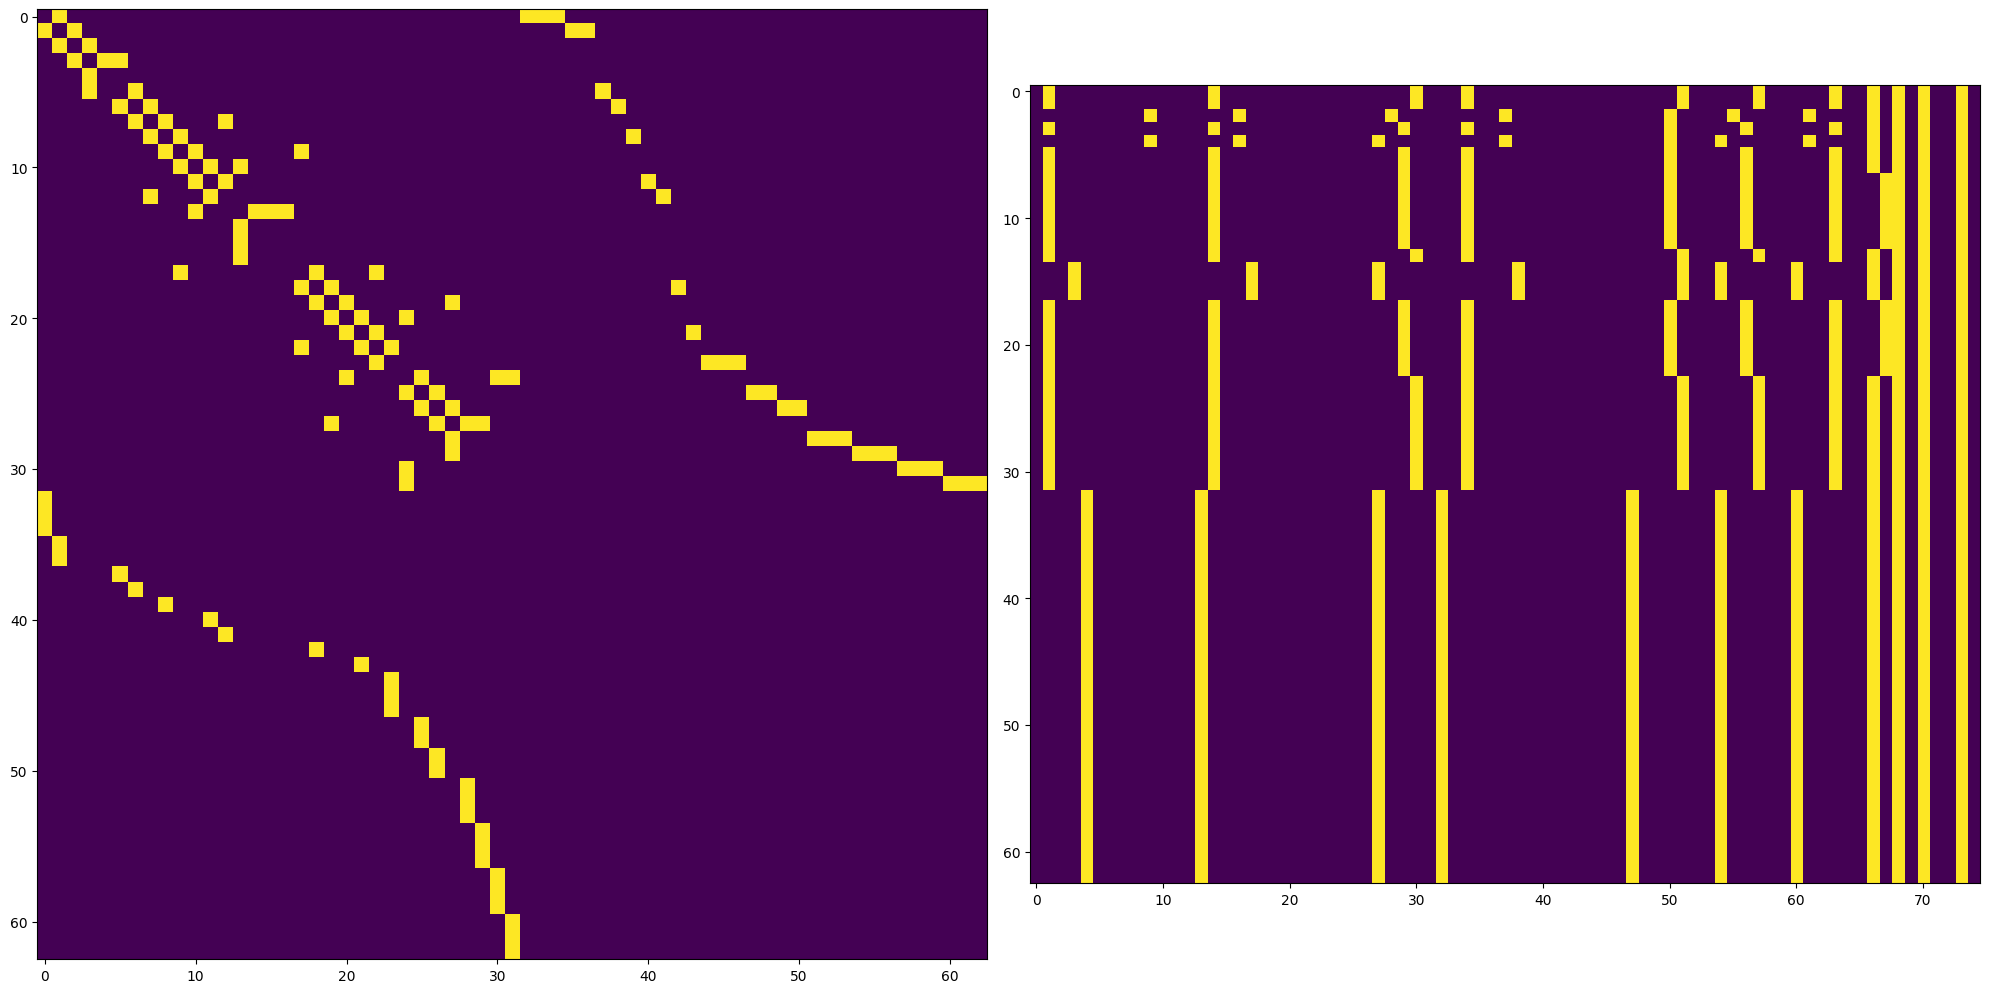

In [92]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(20, 10))

# First subplot
plt.subplot(1, 2, 1)
plt.imshow(y,)

# Second subplot
plt.subplot(1, 2, 2)
plt.imshow(training_dataset[7000].x.numpy(),)

plt.tight_layout()
plt.show()